In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm, trange
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 1.Use librosa to extract audio feature

## 1.1 Draw audio wave diagram

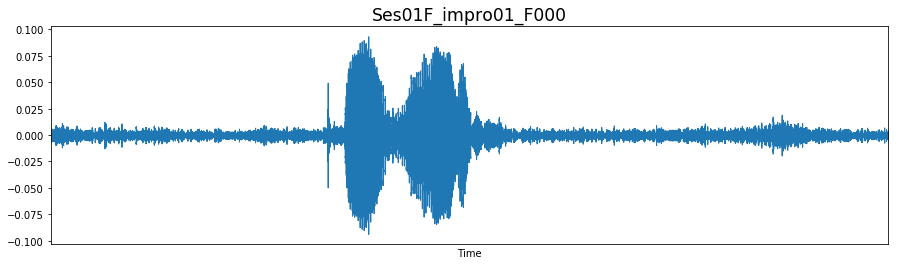

In [4]:
y, sr = librosa.load(audio_file[0])
plt.figure(figsize=(15, 4))
plt.subplot(1, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title(file_name[0], fontsize='xx-large')
plt.xticks([])
plt.savefig('./demo.jpg')
plt.show()

## 1.2 View feature dimensions

In [5]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512)
print('mfcc dimension:', mfcc.shape)
f0 = librosa.feature.zero_crossing_rate(y)
print('f0 dimension:', f0.shape)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
print('cqt dimension:', chroma_cq.shape)
feature_dim = mfcc.shape[0] + f0.shape[0] + chroma_cq.shape[0]
print('feature_dim:', feature_dim)

mfcc dimension: (20, 84)
f0 dimension: (1, 84)
cqt dimension: (12, 84)
feature_dim: 33


## 1.3 Calculate the maximum length to remove singular values

In [6]:
shape_list = []
for i in tqdm(audio_file):
    y, sr = librosa.load(i)   
    f0 = librosa.feature.zero_crossing_rate(y)
    shape_list.append(f0.shape[1])
shape = np.array(shape_list)

MAX_LEN = int(shape.mean() + shape.std()*3)

100%|██████████| 8/8 [00:00<00:00, 12.45it/s]


In [7]:
print('The number of data is {}'.format(len(audio_file)))
print('The max length is {}'.format(MAX_LEN))
print('The feature dimension is {}'.format(feature_dim))

The number of data is 8
The max length is 416
The feature dimension is 33


## 1.4 Three ways to fill less than the maximum length of data

In [8]:
# 1.4.1 Zeros

def feature_process_0(feature, MAX_LEN):
    if feature.shape[0] >= MAX_LEN:
        feature = feature[:MAX_LEN, :]
    return feature

# 1.4.2 Normal distribution

def feature_process_gaus(feature, MAX_LEN):
    if feature.shape[0] >= MAX_LEN:
        feature = feature[:MAX_LEN, :]
    else:
        print(feature.shape)
        mean, std = feature.mean(), feature.std()
        pad = np.random.normal(mean, std, (MAX_LEN-feature.shape[0], feature.shape[1]))
        print(pad.shape)
        feature = np.concatenate((feature, pad), axis=0)
        print(feature.shape)
    return feature

# 1.4.3 Repeat

def feature_process_rep(feature, MAX_LEN):
    if feature.shape[0] >= MAX_LEN:
        pad_feature = feature[:MAX_LEN, :]
    else:
        rep_num = MAX_LEN//feature.shape[0]
        remainder = MAX_LEN%feature.shape[0]
        pad_feature = feature
        if rep_num > 1:
            for i in range(rep_num-1):
                pad_feature = np.concatenate((pad_feature, feature), axis=0)
            pad_feature = np.concatenate((pad_feature, feature[:remainder]), axis=0)
        else:
            pad_feature = np.concatenate((pad_feature, feature[:remainder]), axis=0)
    return pad_feature

## 1.5 Create the features by LibROSA

In [10]:
raw_audio = np.zeros((len(audio_file), MAX_LEN, feature_dim))
for idx, name in enumerate(tqdm(audio_file)):
    
    y, sr = librosa.load(name)
    
    f0 = librosa.feature.zero_crossing_rate(y).T
    f0 = feature_process_0(f0, MAX_LEN)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, htk=True).T
    mfcc = feature_process_0(mfcc, MAX_LEN)
    
    cqt = librosa.feature.chroma_cqt(y=y, sr=sr).T
    cqt = feature_process_0(cqt, MAX_LEN)
    
    raw_audio[idx, :f0.shape[0], :f0.shape[1]] = f0
    raw_audio[idx, :mfcc.shape[0], f0.shape[1]:mfcc.shape[1]+f0.shape[1]] = mfcc
    raw_audio[idx, :cqt.shape[0], f0.shape[1]+mfcc.shape[1]:f0.shape[1]+mfcc.shape[1]+cqt.shape[1]] = cqt

with open('./mfcc_f0_cqt.npy', 'wb') as f:
    np.save(f, raw_audio)

100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


# 2.Use openSMILE to extract audio feature